In [457]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from math import *

In [3]:
def part3q1(y0,alpha,beta,b,c,tf=200,Nt=800,err=1e-6,method="RK45"):
    """
    Part 3 question 1
    Simulate system of 2n nonlinear ODEs

    Input:
    y0: Initial condition, size 2*n array
    alpha,beta,b,c: model parameters
    tf,Nt: Solutions are computed at Nt time steps from t=0 to t=tf (see code below)

    Output:
    tarray: size Nt+1 array
    yarray: Nt+1 x 2*n array containing y at
            each time step including the initial condition.
    """
    
    #Set up parameters, arrays

    n = y0.size//2
    tarray = np.linspace(0,tf,Nt+1)
    yarray = np.zeros((Nt+1,2*n))
    yarray[0,:] = y0


    def RHS(t,y):
        """
        Compute RHS of model
        """
        u = y[:n];v=y[n:]
        r2 = u**2+v**2
        nu = r2*u
        nv = r2*v
        cu = np.roll(u,1)+np.roll(u,-1)
        cv = np.roll(v,1)+np.roll(v,-1)

        dydt = alpha*y
        dydt[:n] += beta*(cu-b*cv)-nu+c*nv+b*(1-alpha)*v
        dydt[n:] += beta*(cv+b*cu)-nv-c*nu-b*(1-alpha)*u

        return dydt


    sol = solve_ivp(RHS, (tarray[0],tarray[-1]), y0, t_eval=tarray, method=method,atol=err,rtol=err)
    yarray = sol.y.T 
    return tarray,yarray

In [802]:
def part3_analyze(display = False):#add/remove input variables if needed
    """
    Part 3 question 1: Analyze dynamics generated by system of ODEs
    """

    #Set parameters
    beta = (25/np.pi)**2
    alpha = 1-2*beta
    b =-1.5
    n = 4000
    cs = [0.5, 1.0, 1.2, 1.3, 1.4, 1.5]

    for c in cs:

        #Set initial conidition
        L = (n-1)/np.sqrt(beta)
        k = 40*np.pi/L
        a0 = np.linspace(0,L,n)
        A0 = np.sqrt(1-k**2)*np.exp(1j*a0)
        y0 = np.zeros(2*n)
        y0[:n]=1+0.2*np.cos(4*k*a0)+0.3*np.sin(7*k*a0)+0.1*A0.real


        #---Example code for computing solution, use/modify/discard as needed---#
        # c = 0.5
        t,y = part3q1(y0,alpha,beta,b,c,tf=20,Nt=2,method='RK45') #for transient, modify tf and other parameters as needed
        y0 = y[-1,:]
        t,y = part3q1(y0,alpha,beta,b,c,method='RK45',err=1e-6)
        u=y[:,100:n-100]


        if display:
            plt.figure()
            plt.contourf(np.arange(n-200),t,u,20)
            plt.title(f'Contour plot of u at c={c}')
            plt.show()

        if c == 0.5:
            from scipy.signal import welch
            fxx,Pxx = welch(u.T,fs=1/t[1])
            plt.contourf(np.arange(3800), fxx, Pxx.T, 20)
            plt.colorbar()  
            plt.xlabel('i')
            plt.ylabel('Frequency')
            plt.title(f'Contour plot to show dominant frequencies at c={c}')
            plt.show()

            A = np.transpose(u - np.mean(u, axis=0))
            U, _, _ = np.linalg.svd(A.T @ A)
            Cov = 1/(u.shape[1]-1)*A.dot(A.T)
            total_variance = np.sum(np.diag(Cov))
            evals, _ = np.linalg.eig(Cov)
            plt.plot((np.cumsum(np.abs(evals))/total_variance)[:100],color='blue')
            plt.title('Variance explained by the first 100 Principal Components, c=0.5')
            plt.xlabel('PC')
            plt.ylabel('Cumulative Variance')
            plt.show()
            
            plt.plot(U[:, 0], color='blue')
            plt.xlabel('i')
            plt.ylabel('$PC_i$')
            plt.title('First Principal Component when c=0.5')
            plt.show()

        if c == 1.3:
            from scipy.spatial.distance import pdist
            # remove transient states
            y0 = np.zeros(2*n)
            y0[:n]=1+0.2*np.cos(4*k*a0)+0.3*np.sin(7*k*a0)+0.1*A0.real
            t,y = part3q1(y0,alpha,beta,b,c,tf=200,Nt=2,method='RK45') #more time steps to get to transient
            y0 = y[-1,:]
            t,y = part3q1(y0,alpha,beta,b,c,method='RK45',err=1e-6)
            ut=y[:,100:n-100]

            plt.figure()
            plt.contourf(np.arange(n-200),t,ut,20)
            plt.title(f'Contour plot of u at c={c}, transient states removed')
            plt.show()

            fxx,Pxx = welch(ut.T,fs=1/t[1])
            plt.contourf(np.arange(3800), fxx, Pxx.T, 20)
            plt.colorbar()
            plt.xlabel('i')
            plt.ylabel('Frequency')
            plt.title(f'Contour plot to show dominant frequencies at c={c}, with transient states removed')
            plt.show()

            Dt = pdist(ut)
            Ct = []
            epsilonst = np.linspace(min(Dt)+1, max(Dt), 200)[::-1]
            for epsilon in epsilonst:
                Dt = Dt[Dt<epsilon]
                Ct.append(Dt.size/comb(3800, 2))

            D = pdist(u)
            C = []
            for epsilon in epsilonst:
                D = D[D<epsilon]
                C.append(D.size/comb(3800, 2))

            plt.plot(np.log(epsilonst), np.log(C), label='Before cutting transient states')
            plt.plot(np.log(epsilonst), np.log(Ct), label = 'Transient state cut')
            grad, intercept = np.polyfit(np.log(epsilonst[-50:-20]), np.log(C[-50:-20]), deg=1)
            yfit = np.poly1d([grad, intercept])
            plt.plot(np.log(epsilonst[-50:-20]),np.log(np.exp(intercept)*np.power(epsilonst[-50:-20],grad)), label='slope = '+str(grad), color='lime')
            grad1, intercept1 = np.polyfit(np.log(epsilonst[85:135]), np.log(Ct[85:135]), deg=1)
            yfit = np.poly1d([grad1, intercept1])
            plt.plot(np.log(epsilonst[85:135]),np.log(np.exp(intercept1)*np.power(epsilonst[85:135],grad1)), label='slope = '+str(grad1))
            plt.legend()
            plt.xlabel('ln(epsilon)')
            plt.ylabel('ln(Corrlation Sum)')
            plt.show()

            A = np.transpose(ut - np.mean(ut, axis=0))
            U, _, _ = np.linalg.svd(A.T @ A)
            Cov = 1/(u.shape[1]-1)*A.dot(A.T)
            total_variance = np.sum(np.diag(Cov))
            evals, _ = np.linalg.eig(Cov)
            plt.plot((np.cumsum(np.abs(evals))/total_variance)[:100],color='blue')
            plt.title('Variance explained by the first 100 Principal Components, c=1.3')
            plt.xlabel('PC')
            plt.ylabel('Cumulative Variance')
            plt.show()
            
            plt.plot(U[:, 0], color='blue')
            plt.xlabel('i')
            plt.ylabel('$PC_i$')
            plt.title('First Principal Component when c=1.3')
            plt.show()
    #-------------------------------------------#

    #Add code here


    return None #modify if needed

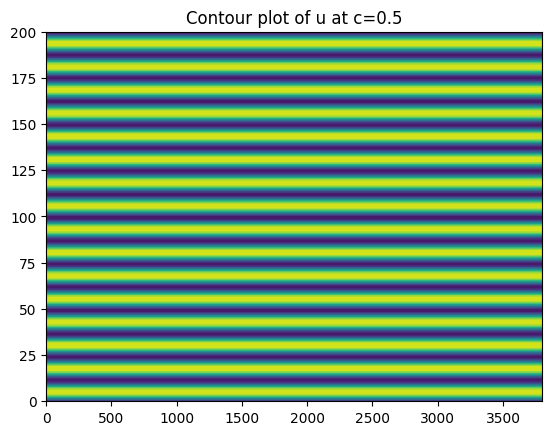

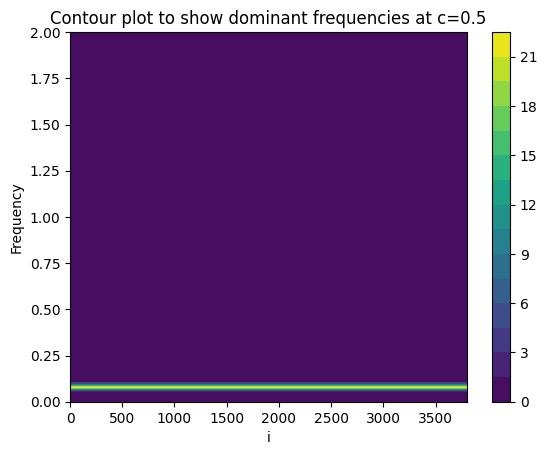

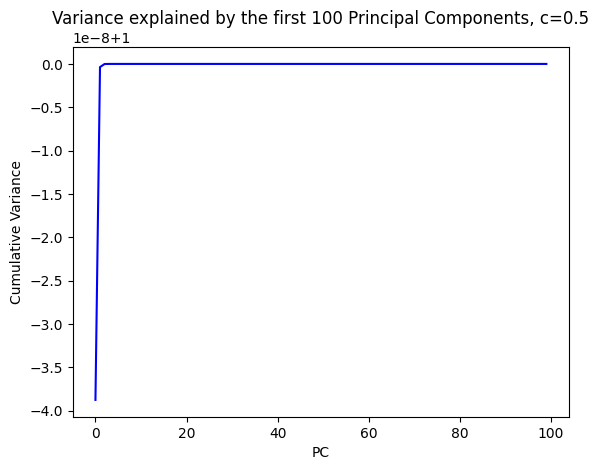

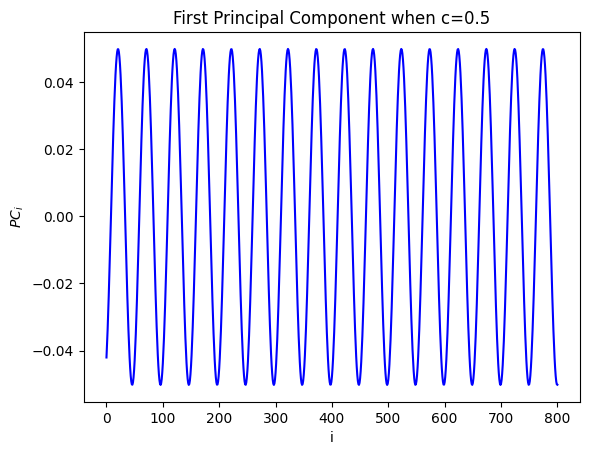

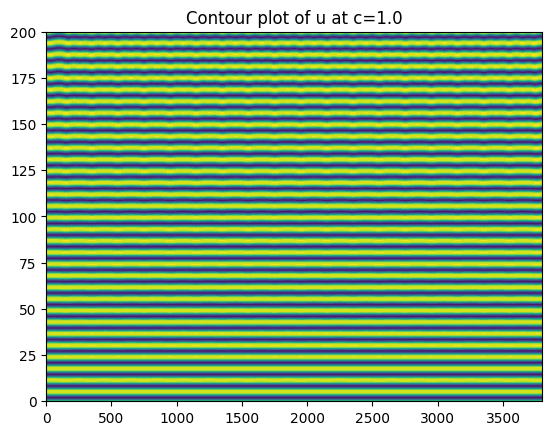

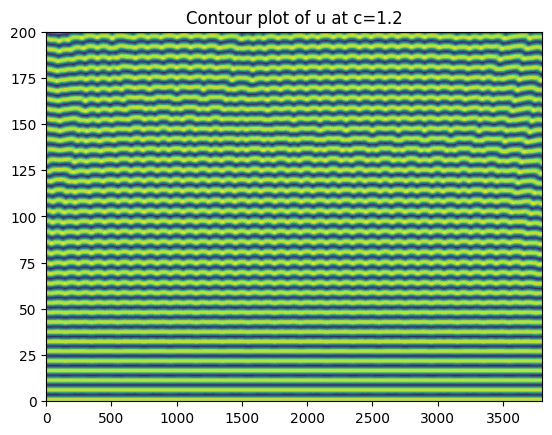

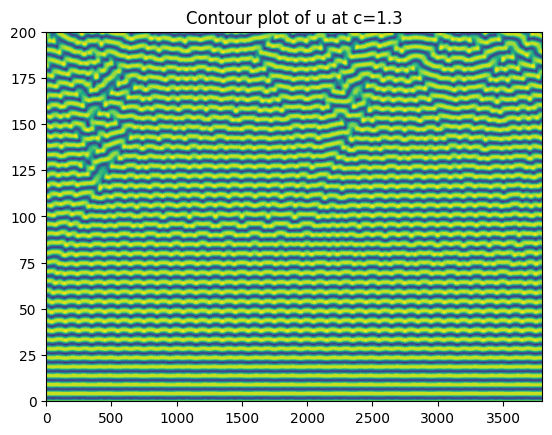

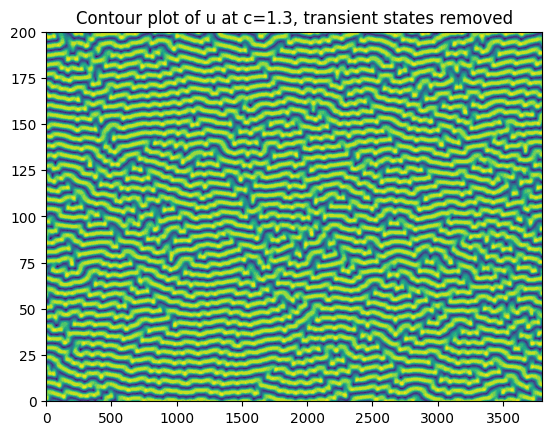

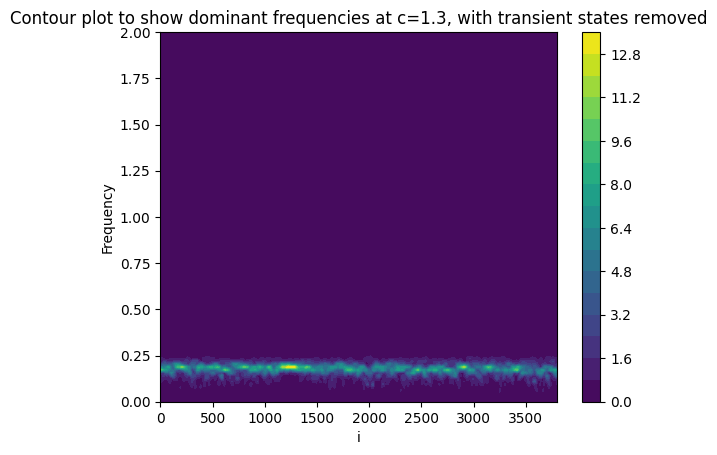

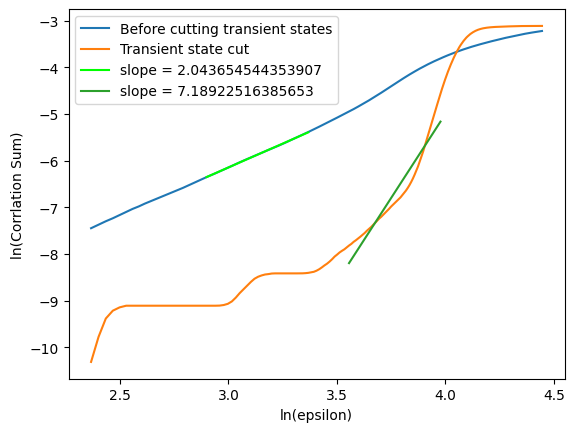

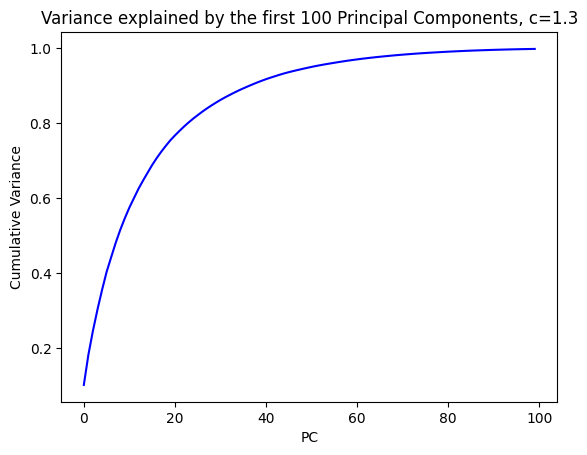

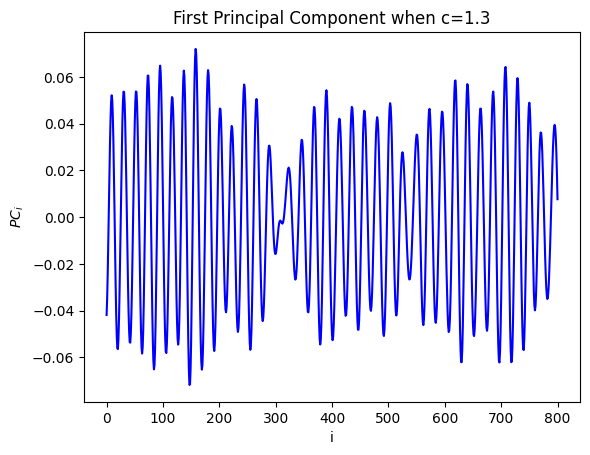

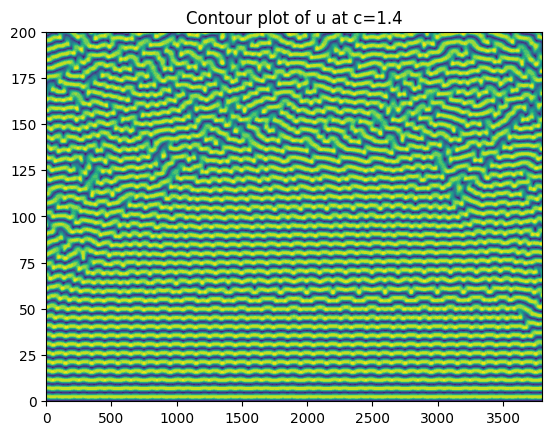

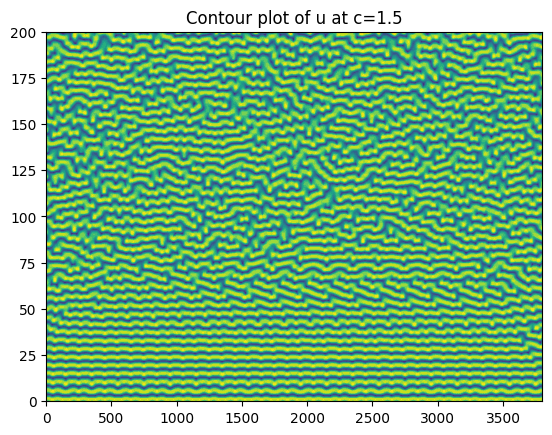

In [803]:
part3_analyze(display=True)

In [731]:
beta = (25/np.pi)**2
alpha = 1-2*beta
b =-1.5
n = 4000
c=1.3

#Set initial conidition
L = (n-1)/np.sqrt(beta)
k = 40*np.pi/L
a0 = np.linspace(0,L,n)
A0 = np.sqrt(1-k**2)*np.exp(1j*a0)
y0 = np.zeros(2*n)
y0[:n]=1+0.2*np.cos(4*k*a0)+0.3*np.sin(7*k*a0)+0.1*A0.real

#---Example code for computing solution, use/modify/discard as needed---#
c = 1.3
t,y = part3q1(y0,alpha,beta,b,c,tf=20,Nt=2,method='RK45') #for transient, modify tf and other parameters as needed
y0 = y[-1,:]
t,y = part3q1(y0,alpha,beta,b,c,method='RK45',err=1e-6)
u,v = y[:,100:n-100],y[100:-100,n:]

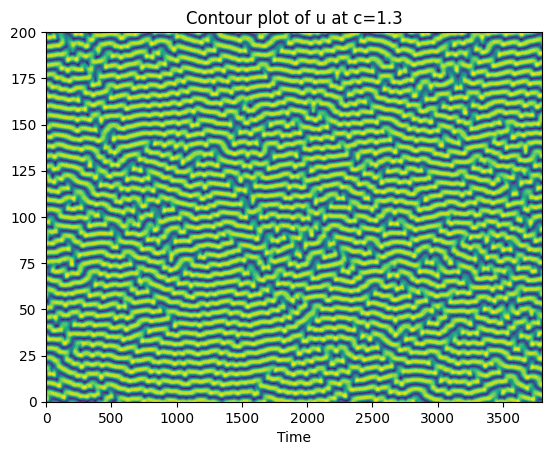

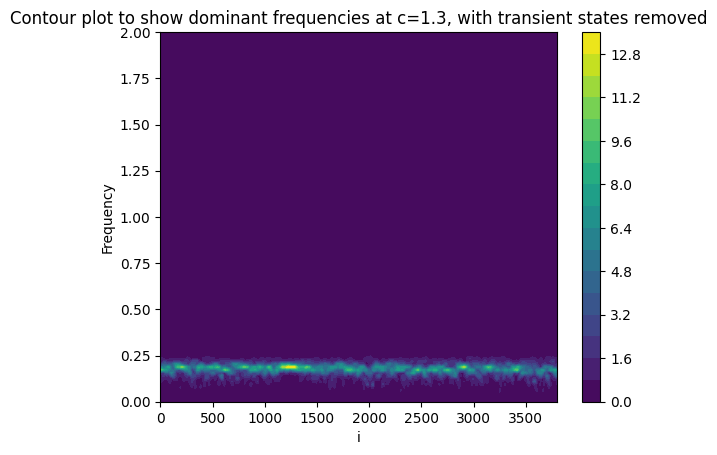

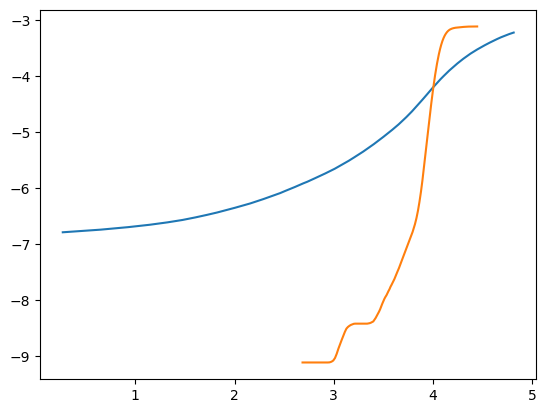

In [787]:
from scipy.spatial.distance import pdist
D = pdist(u)
C = []
epsilons = np.linspace(min(D)+1, max(D), 200)[::-1]
for epsilon in epsilonst:
    D = D[D<epsilon]
    C.append(D.size/comb(3800, 2))


y0 = np.zeros(2*n)
y0[:n]=1+0.2*np.cos(4*k*a0)+0.3*np.sin(7*k*a0)+0.1*A0.real
t,y = part3q1(y0,alpha,beta,b,c,tf=200,Nt=2,method='RK45') #more time steps to get to transient
y0 = y[-1,:]
t,y = part3q1(y0,alpha,beta,b,c,method='RK45',err=1e-6)
ut=y[:,100:n-100]

plt.figure()
plt.contourf(np.arange(n-200),t,ut,20)
plt.title(f'Contour plot of u at c={c}')
plt.xlabel('Time')
plt.show()

fxx,Pxx = welch(ut.T,fs=1/t[1])
plt.contourf(np.arange(3800), fxx, Pxx.T, 20)
plt.colorbar()
plt.xlabel('i')
plt.ylabel('Frequency')
plt.title(f'Contour plot to show dominant frequencies at c={c}, with transient states removed')
plt.show()

Dt = pdist(ut)
Ct = []
epsilonst = np.linspace(min(Dt)+5, max(Dt), 200)[::-1]
for epsilon in epsilonst:
    Dt = Dt[Dt<epsilon]
    Ct.append(Dt.size/comb(3800, 2))

plt.plot(np.log(epsilons), np.log(C))
plt.plot(np.log(epsilonst), np.log(Ct))

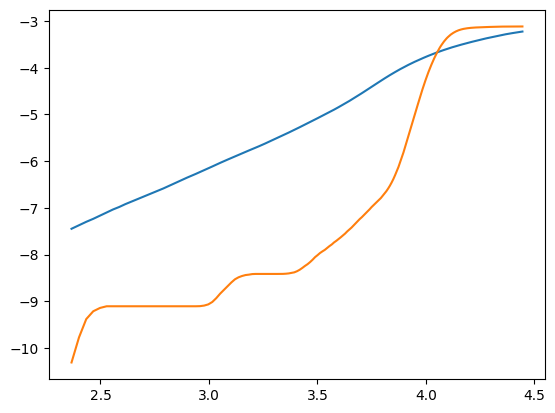

In [705]:
Dt = pdist(ut)
Ct = []
epsilonst = np.linspace(min(Dt)+1, max(Dt), 200)[::-1]
for epsilon in epsilonst:
    Dt = Dt[Dt<epsilon]
    Ct.append(Dt.size/comb(3800, 2))

D = pdist(u)
C = []
epsilons = np.linspace(min(D)+1, max(D), 200)[::-1]
for epsilon in epsilonst:
    D = D[D<epsilon]
    C.append(D.size/comb(3800, 2))

plt.plot(np.log(epsilonst), np.log(C))
plt.plot(np.log(epsilonst), np.log(Ct))

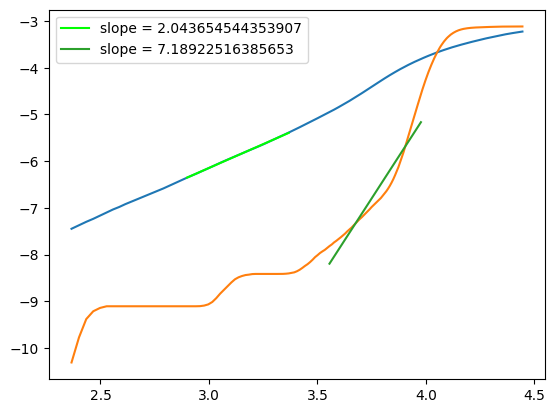

In [726]:
plt.plot(np.log(epsilonst), np.log(C))
plt.plot(np.log(epsilonst), np.log(Ct))
grad, intercept = np.polyfit(np.log(epsilonst[-50:-20]), np.log(C[-50:-20]), deg=1)
yfit = np.poly1d([grad, intercept])
plt.plot(np.log(epsilonst[-50:-20]),np.log(np.exp(intercept)*np.power(epsilonst[-50:-20],grad)), label='slope = '+str(grad), color='lime')
grad1, intercept1 = np.polyfit(np.log(epsilonst[85:135]), np.log(Ct[85:135]), deg=1)
yfit = np.poly1d([grad1, intercept1])
plt.plot(np.log(epsilonst[85:135]),np.log(np.exp(intercept1)*np.power(epsilonst[85:135],grad1)), label='slope = '+str(grad1))
plt.legend()
plt.show()

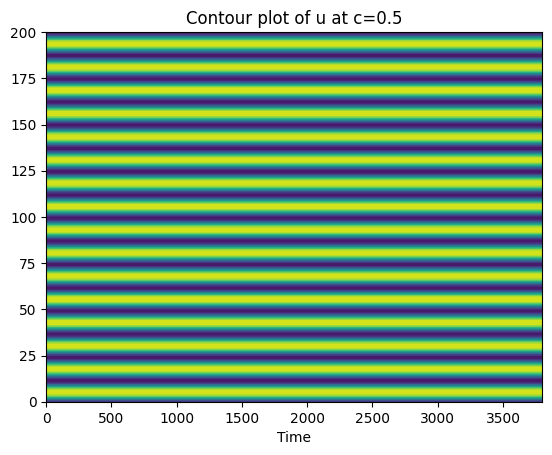

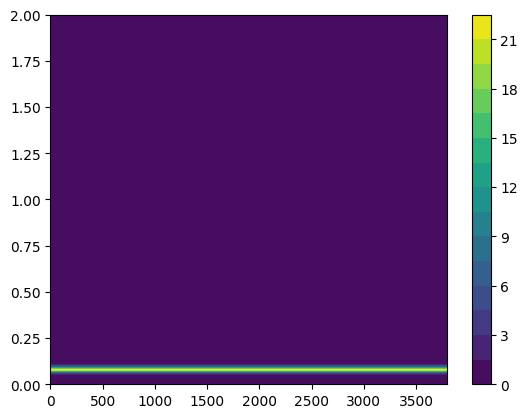

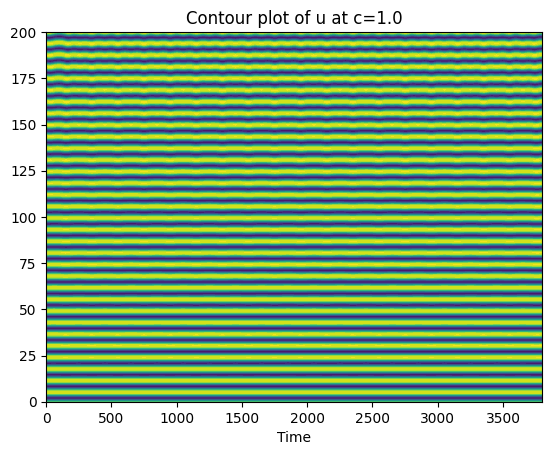

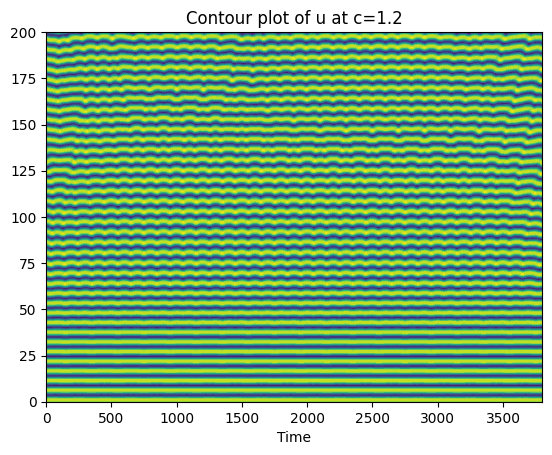

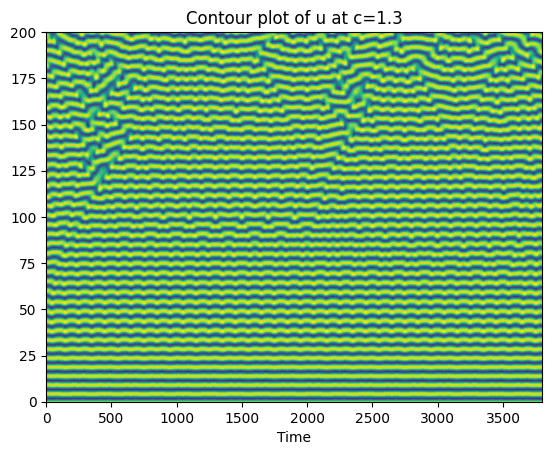

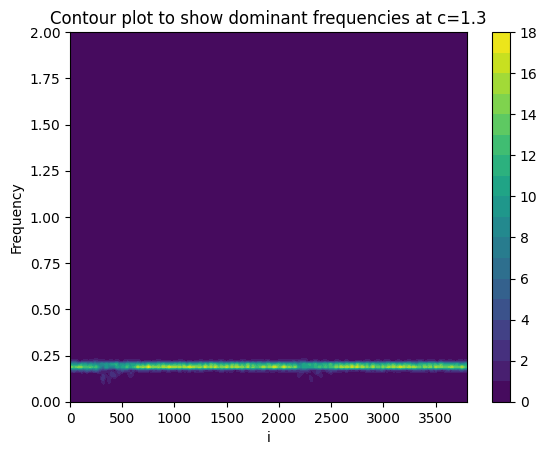

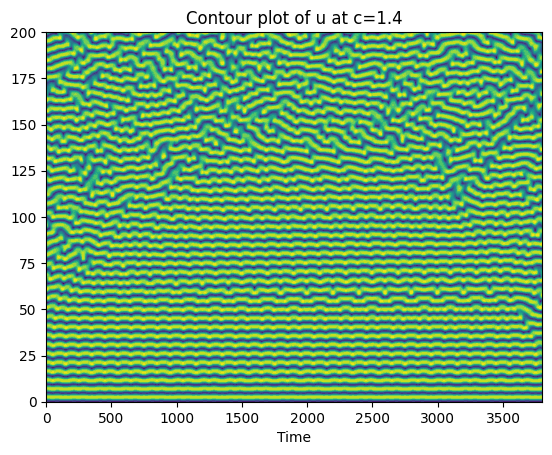

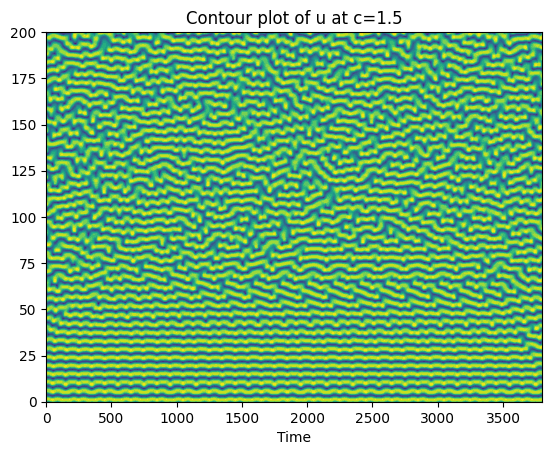

In [343]:
part3_analyze(display=True)

f= [0.171875]


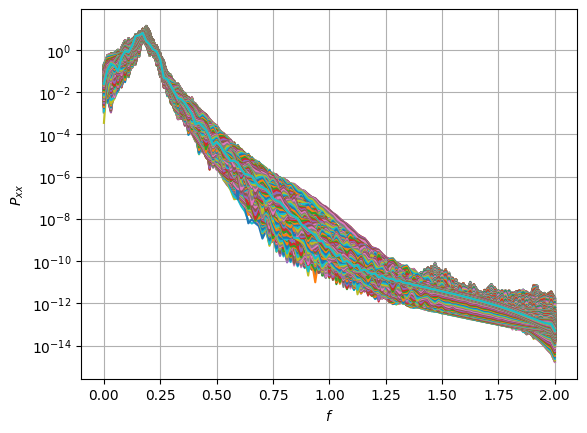

In [338]:
#IMPORTANT: A larger T is needed for the simulation above 
#to get an accurate estimate of f
from scipy.signal import welch
#add code here
fxx,Pxx = welch(u.T,fs=1/t[1])
plt.figure()
plt.semilogy(fxx,Pxx.T)
plt.xlabel(r'$f$')
plt.ylabel(r'$P_{xx}$')
plt.grid()
# print("dt,1/f=",t[1]-t[0],1/f)

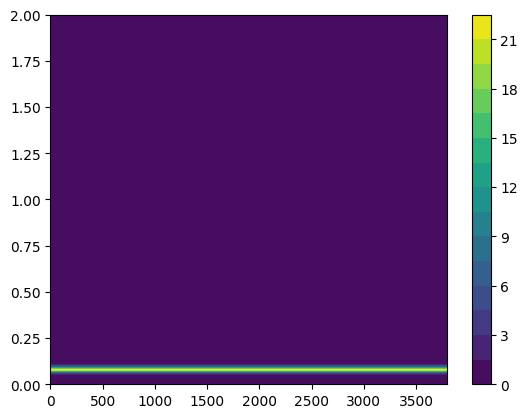

In [336]:
plt.contourf(np.arange(3800), fxx, Pxx.T, 20)
plt.colorbar()

f is dominant freqency

In [686]:
# do both !

from scipy.spatial.distance import pdist
D = pdist(u)
C = []
epsilons = np.linspace(min(D)+1, max(D), 200)[::-1]
for epsilon in epsilons:
    D = D[D<epsilon]
    C.append(D.size/comb(3800, 2))

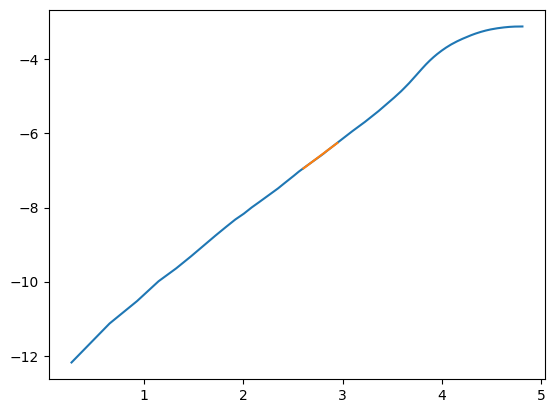

In [688]:
plt.plot(np.log(epsilons), np.log(C))
grad, intercept = np.polyfit(np.log(epsilons[-30:-20]), np.log(C[-30:-20]), deg=1)
yfit = np.poly1d([grad, intercept])
# plt.plot(epsilons[165:180], 10 ** yfit(np.log(epsilons[165:180])))
plt.plot(np.log(epsilons[-30:-20]),np.log(np.exp(intercept)*np.power(epsilons[-30:-20],grad)), label='slope = '+str(grad))
plt.show()

In [689]:
grad, Pxx.shape

(2.0108932387072054, (3800, 129))

(801, 3800)


Text(0, 0.5, '$x(t+\\tau)$')

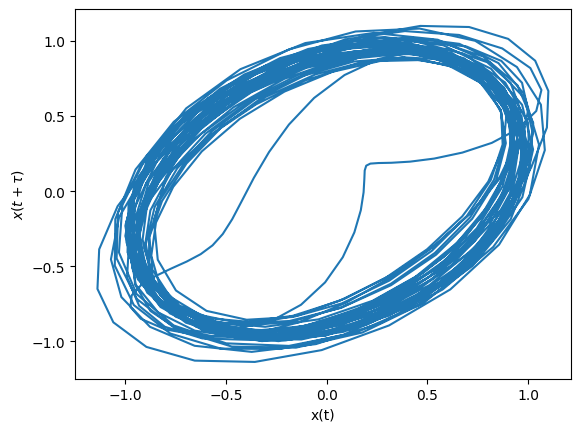

In [761]:
tau = 1/(5*0.175)
Del = int(tau/t[1])
print(u.shape)
v1 = np.vstack([u[:-2*Del, 0],u[Del:-Del, 0],u[2*Del:, 0]])
v10 = v1.copy()
plt.figure()
plt.plot(v1[0],v1[1])
plt.xlabel('x(t)')
plt.ylabel(r'$x(t+\tau)$')


(801, 3800)


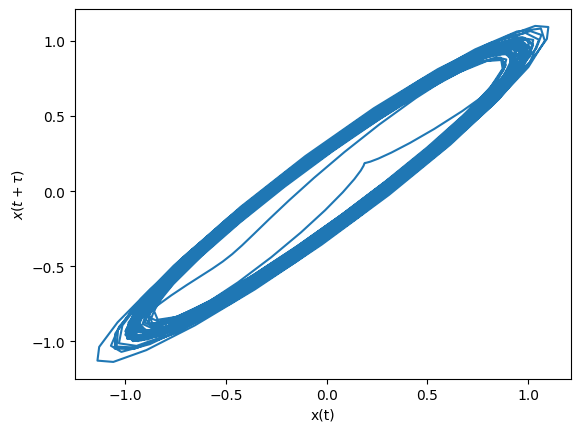

In [762]:
tau = tau/4
Del = int(tau/t[1])
print(u.shape)
v1 = np.vstack([u[:-2*Del, 0],u[Del:-Del, 0],u[2*Del:, 0]])
plt.figure()
plt.plot(v1[0],v1[1])
plt.xlabel('x(t)')
plt.ylabel(r'$x(t+\tau)$')
plt.show()

Text(0.5, 0, 'z')

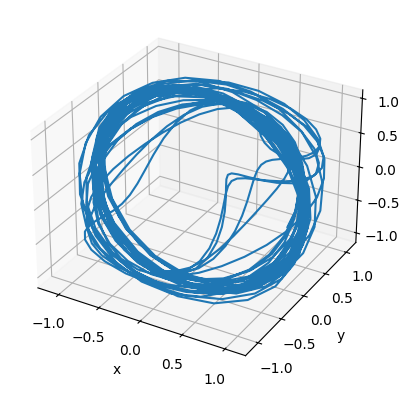

In [388]:
#add code here
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.plot(v1[0],v1[1],v1[2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [385]:
print(np.corrcoef(v10[0],v10[1])[0,1]) #1st time delay (lower correlation is better here)
print(np.corrcoef(v1[0],v1[1])[0,1]) #2nd time delay

0.46082897187673205
0.46082897187673205


In [391]:
np.corrcoef(u)

array([[1.        , 0.96449579, 0.8510289 , ..., 0.0929926 , 0.12897999,
        0.15522208],
       [0.96449579, 1.        , 0.95928811, ..., 0.10415218, 0.15301749,
        0.19071197],
       [0.8510289 , 0.95928811, 1.        , ..., 0.11466804, 0.17230498,
        0.21767404],
       ...,
       [0.0929926 , 0.10415218, 0.11466804, ..., 1.        , 0.96509867,
        0.85534934],
       [0.12897999, 0.15301749, 0.17230498, ..., 0.96509867, 1.        ,
        0.96092327],
       [0.15522208, 0.19071197, 0.21767404, ..., 0.85534934, 0.96092327,
        1.        ]])

In [397]:
pdist(u[::4]).shape

(20100,)

In [764]:
M, N = u.shape
A= np.transpose(u-u.mean(axis=0))
U, _, _ = np.linalg.svd(A)
U.shape

(3800, 3800)

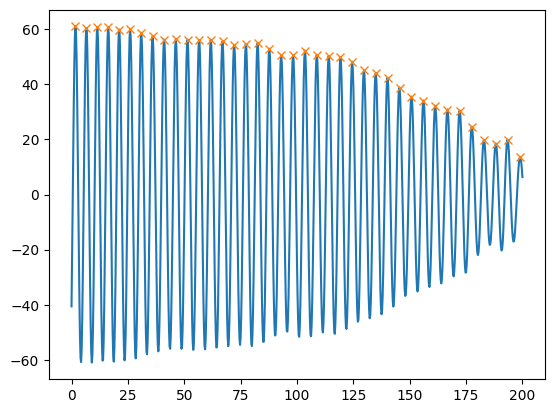

In [765]:
dx = np.diff((u @ U)[:, 0])
d2x = dx[1:]*dx[:-1]
ind = np.argwhere(d2x<0)
plt.plot(t, (u @ U)[:, 0])
plt.plot(t[ind[::2]+1],(u @ U)[:, 0][ind[::2]+1], 'x')

In [594]:
Cov = 1/(M-1)*A.dot(A.T)
total_variance = np.sum(np.diag(Cov))
evals, evects = np.linalg.eig(Cov)
np.cumsum(evals) / total_variance
# plt.plot((np.cumsum(evals)/total_variance)[:100])
# plt.show()

array([0.65737334+0.j, 0.71110379+0.j, 0.75929722+0.j, ...,
       1.        +0.j, 1.        +0.j, 1.        +0.j])

In [768]:
peaks = (u @ U)[:, 0][ind[::2]+1]
D1 = pdist(peaks)
C1 = []
epsilons = np.linspace(min(D1)+1, max(D1), 200)[::-1]
for epsilon in epsilons:
    D1 = D1[D1<epsilon]
    C1.append(D1.size/comb(39, 2))

In [772]:
peaks

array([[61.01663809],
       [60.44922015],
       [60.79785063],
       [60.81484283],
       [59.89090625],
       [60.04910571],
       [58.72179367],
       [57.4320825 ],
       [56.26638174],
       [56.31655504],
       [56.21997433],
       [55.94148857],
       [56.24288516],
       [55.56776113],
       [54.13423347],
       [54.55273597],
       [54.86179676],
       [52.95728836],
       [50.58542162],
       [50.56703192],
       [52.2921926 ],
       [50.65216129],
       [50.22030568],
       [49.92720991],
       [48.20109374],
       [45.19823759],
       [44.13757911],
       [42.36602188],
       [38.77220284],
       [35.53927299],
       [34.13372351],
       [32.27264412],
       [30.87021911],
       [30.48140292],
       [24.62632901],
       [19.85978741],
       [18.51235112],
       [19.91992514],
       [13.60480626]])

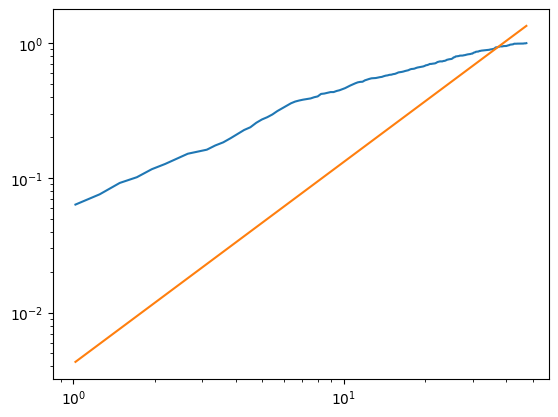

In [769]:
plt.loglog(epsilons, C1)
grad, intercept = np.polyfit(np.log(epsilons), np.log(C1), deg=1)
yfit = np.poly1d([grad, intercept])
plt.loglog(epsilons, 10 ** yfit(np.log(epsilons)))
plt.show()

In [770]:
grad

0.6486175878097106

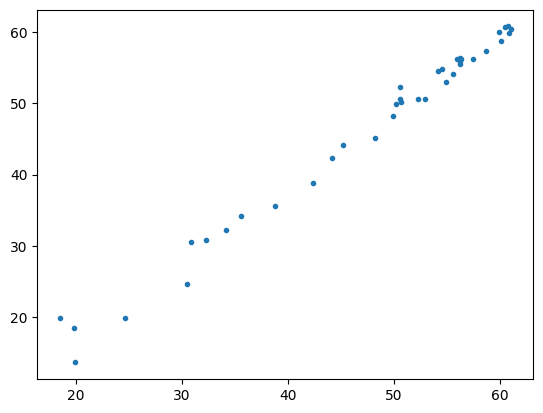

In [776]:
plt.plot(peaks[:-1], peaks[1:], '.')

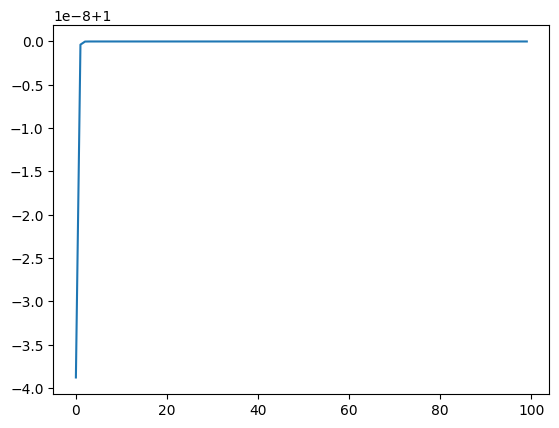

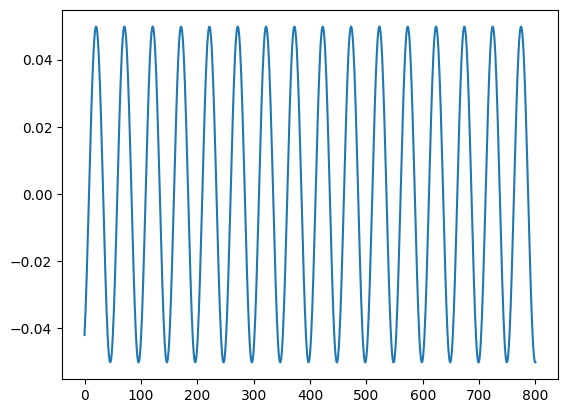

In [800]:
cs = [0.5]

for c in cs:

    #Set initial conidition
    L = (n-1)/np.sqrt(beta)
    k = 40*np.pi/L
    a0 = np.linspace(0,L,n)
    A0 = np.sqrt(1-k**2)*np.exp(1j*a0)
    y0 = np.zeros(2*n)
    y0[:n]=1+0.2*np.cos(4*k*a0)+0.3*np.sin(7*k*a0)+0.1*A0.real


    #---Example code for computing solution, use/modify/discard as needed---#
    # c = 0.5
    t,y = part3q1(y0,alpha,beta,b,c,tf=20,Nt=2,method='RK45') #for transient, modify tf and other parameters as needed
    y0 = y[-1,:]
    t,y = part3q1(y0,alpha,beta,b,c,method='RK45',err=1e-6)
    u=y[:,100:n-100]

    A = np.transpose(u - np.mean(u, axis=0))
    U, _, _ = np.linalg.svd(A.T @ A)
    vals, vects = np.linalg.eigh(A.T@A)
    Cov = 1/(u.shape[1]-1)*A.dot(A.T)
    total_variance = np.sum(np.diag(Cov))
    evals, evects = np.linalg.eig(Cov)
    plt.plot((np.cumsum(np.abs(evals))/total_variance)[:100])
    plt.show()
    
    plt.plot(U[:, 0])
    plt.show()

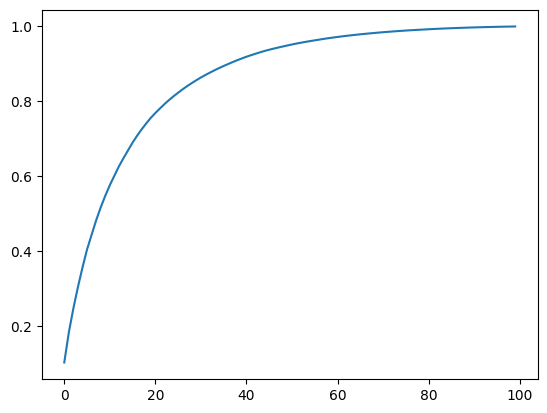

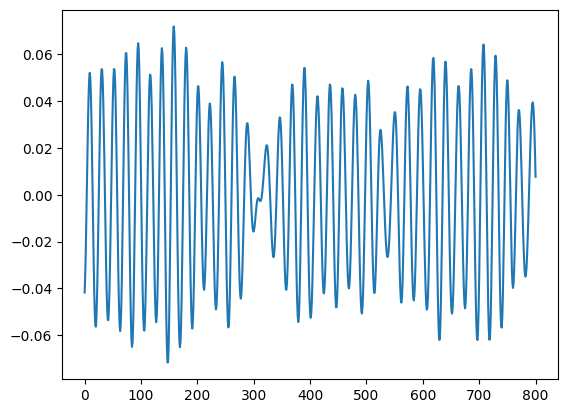

In [801]:
A = np.transpose(ut - np.mean(ut, axis=0))
U, _, _ = np.linalg.svd(A.T @ A)
vals, vects = np.linalg.eigh(A.T@A)
Cov = 1/(u.shape[1]-1)*A.dot(A.T)
total_variance = np.sum(np.diag(Cov))
evals, evects = np.linalg.eig(Cov)
plt.plot((np.cumsum(np.abs(evals))/total_variance)[:100])
plt.show()
plt.plot(U[:, 0])
plt.show()